# Packages

In [69]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pySODM.models.base import ODE
from covid19_DTM.data.utils import construct_initN
from covid19_DTM.models.TDPF import ramp_fun
from covid19_DTM.models.TDPF import make_seasonality_function
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data
import csv
from csv import DictReader
from matplotlib import font_manager
import string
import os
from datetime import datetime

In [70]:
abs_dir = os.getcwd()
# Verify that the paths exist and if not, generate them
result_folder = '../../results/QALY_model/postponed_healthcare/analysis/UZG_data/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# Extract data

In [71]:
# location
abs_dir = os.getcwd()
rel_dir = '../../data/QALY_model/interim/postponed_healthcare/'
# baseline
file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()
# raw data
file_name = 'MZG_2016_2021.csv'
types_dict = {'APR_MDC_key': str}
raw = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
raw = raw.groupby(['APR_MDC_key','date']).sum()
raw.index = raw.index.set_levels([raw.index.levels[0], pd.to_datetime(raw.index.levels[1])])
# normalised data
file_name = 'MZG_2020_2021_normalized.csv'
types_dict = {'APR_MDC_key': str}
normalised = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True)
MDC_keys = normalised.index.get_level_values('APR_MDC_key').unique().values

/tmp/ipykernel_2244972/376742881.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  normalised = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True)


# Compute reductions based on data

In [93]:
# between what dates?
start = datetime(2020,1,1)
stop = datetime(2021,1,1)
# per APR_MDC_key
strat = 100*raw.loc[slice(None),slice(start,stop)].groupby(by='APR_MDC_key').mean()/baseline['mean'].groupby(by='APR_MDC_key').mean()
# total
tot = np.sum(strat.values*baseline['mean'].groupby(by='APR_MDC_key').mean().values)/np.sum(baseline['mean'].groupby(by='APR_MDC_key').mean().values)
# print result
d = -(100-strat)
d.to_csv('hoi.csv')
print(-(100-strat))
print(-(100-tot))

APR_MDC_key
00   -59.500529
01   -16.079226
02     3.936761
03   -20.921843
04    29.447631
05   -12.130552
06    -2.751970
07     9.547912
08    -8.261668
09   -18.143758
10    -5.834571
11    -1.349070
12   -15.725483
13   -21.733833
14    -9.206857
15    -6.098643
16    -4.513453
17    -5.919766
18    -8.361092
19   -22.205875
20   -24.873270
21   -14.732558
22   -42.442066
23   -14.197432
24   -40.679284
25   -19.060957
AA    -6.042992
PP     0.799837
dtype: float64
-8.822381402557141


# Smooth data

In [74]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [75]:
# filter settings
window = 3
order = 1
# copy data
baseline_smooth = pd.DataFrame(0, index=baseline.index, columns=baseline.columns)
normalised_smooth = pd.DataFrame(0, index=normalised.index, columns=normalised.columns)

for MDC_key in MDC_keys:
    for column in baseline.columns:
        baseline_smooth.loc[(MDC_key,slice(None)), column] = savitzky_golay(baseline.loc[MDC_key,slice(None)][column].values,window,order)
        normalised_smooth.loc[(MDC_key,slice(None)), column] = savitzky_golay(normalised.loc[MDC_key,slice(None)][column].values,window,order)

/tmp/ipykernel_2244972/681913515.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[31.45       33.90833333 34.95833333 35.6        36.06666667 35.43333333
 34.53333333 34.28333333 34.45       33.65       32.93333333 33.28333333
 33.03333333 31.93333333 31.18333333 30.21666667 29.93333333 29.83333333
 30.9        32.38333333 32.63333333 32.23333333 31.76666667 30.9
 31.01666667 31.         30.4        28.18333333 26.45       25.13333333
 25.4        26.25       27.56666667 27.63333333 27.7        28.91666667
 31.28333333 32.89166667 32.925      33.075      33.7        34.03333333
 31.86666667 29.58333333 28.51666667 28.93333333 29.         30.01666667
 31.1        31.04166667 27.74166667 25.29166667 24.65      ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  baseline_smooth.loc[(MDC_key,slice(None)), column] = savitzky_golay(baseline.loc[MDC_key,slice(None)][column].val

In [76]:
lockdowns = [(pd.to_datetime('2020-03-15'), pd.to_datetime('2020-05-07')),
                 (pd.to_datetime('2020-10-19'), pd.to_datetime('2020-11-18')),
                 (pd.to_datetime('2021-03-07'), pd.to_datetime('2021-04-18')),
                 (pd.to_datetime('2021-10-10'), pd.to_datetime('2021-12-25'))]

# Normalized data

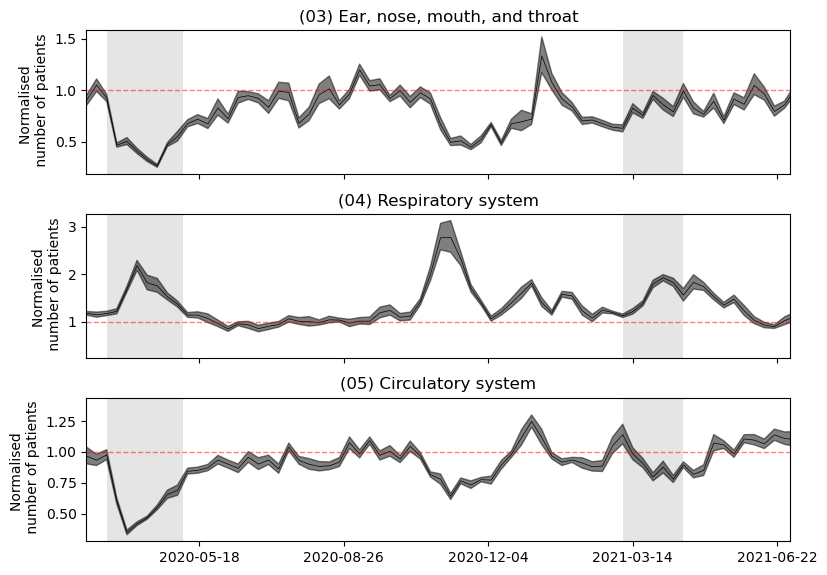

In [77]:
plot_start = datetime(2020, 3, 1)
plot_end = datetime(2021, 7, 1)
MDC_plot = ['03','04','05']
titles = ['(03) Ear, nose, mouth, and throat', '(04) Respiratory system', '(05) Circulatory system']

fig,axs=plt.subplots(len(MDC_plot),1,figsize=(8.3,0.5*11.7),sharex=True)
time = normalised.index.get_level_values('date').unique()
for idx,(MDC,title) in enumerate(zip(MDC_plot,titles)):
    # plot lockdown
    for lockdown in lockdowns:
        lockdown_start = lockdown[0]
        lockdown_end = lockdown[1]
        if lockdown_start in time:
            axs[idx].axvspan(lockdown_start,lockdown_end, facecolor='black', alpha=0.1)
    # plot data
    axs[idx].plot(time, normalised.loc[MDC]['mean'], label=title, color='black',linewidth=0.5)
    axs[idx].fill_between(time,normalised.loc[MDC]['q0.025'],normalised.loc[MDC]['q0.975'], color='black',alpha=0.5)
    # formatting
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    axs[idx].set_title(title)
    axs[idx].set_ylabel('Normalised \n number of patients',size=10)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].set_xlim([plot_start, plot_end])
fig.tight_layout()
fig.savefig(os.path.join(result_folder,'UZG_normalized.pdf'))

# UZG normalized smooth

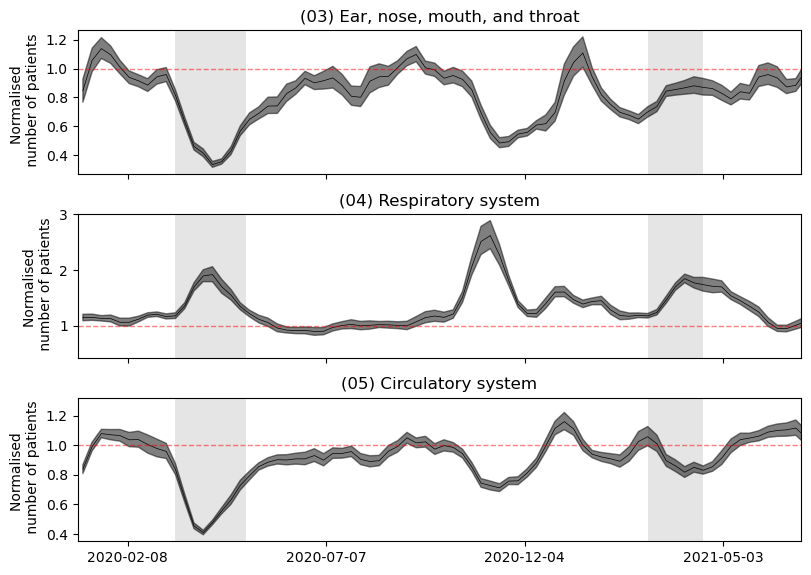

In [78]:
plot_start = datetime(2020, 1, 1)
plot_end = datetime(2021, 7, 1)
MDC_plot = ['03', '04','05']
titles = ['(03) Ear, nose, mouth, and throat', '(04) Respiratory system', '(05) Circulatory system']

fig,axs=plt.subplots(len(MDC_plot),1,figsize=(8.3,0.5*11.7),sharex=True)
time = normalised_smooth.index.get_level_values('date').unique()
for idx,(MDC,title) in enumerate(zip(MDC_plot,titles)):
    # plot lockdown
    for lockdown in lockdowns:
        lockdown_start = lockdown[0]
        lockdown_end = lockdown[1]
        if lockdown_start in time:
            axs[idx].axvspan(lockdown_start,lockdown_end, facecolor='black', alpha=0.1)
    # plot data
    axs[idx].plot(time, normalised_smooth.loc[MDC]['mean'], label=title, color='black',linewidth=0.5)
    axs[idx].fill_between(time,normalised_smooth.loc[MDC]['q0.025'],normalised_smooth.loc[MDC]['q0.975'], color='black',alpha=0.5)
    # formatting
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    axs[idx].set_title(title)
    axs[idx].set_ylabel('Normalised \n number of patients',size=10)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].set_xlim([plot_start, plot_end])
fig.tight_layout()
fig.savefig(os.path.join(result_folder,'UZG_normalized.pdf'))

# Introduction figure

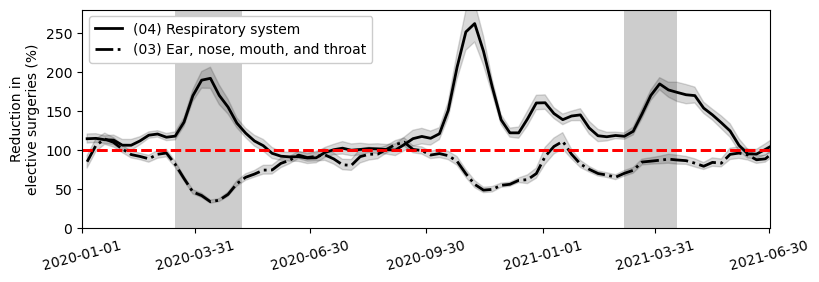

In [79]:
plot_start = datetime(2020, 1, 1)
plot_end = datetime(2021, 7, 1)
MDC_plot = ['04','03',]
titles = ['(04) Respiratory system', '(03) Ear, nose, mouth, and throat']
colors = ['black', 'black']
linestyles = ['-', '-.']

fig,ax=plt.subplots(figsize=(8.3,0.25*11.7))
time = normalised_smooth.index.get_level_values('date').unique()
for idx,(MDC,title,color,linestyle) in enumerate(zip(MDC_plot,titles,colors,linestyles)):
    # plot lockdown
    for lockdown in lockdowns:
        lockdown_start = lockdown[0]
        lockdown_end = lockdown[1]
        if lockdown_start in time:
            ax.axvspan(lockdown_start,lockdown_end, facecolor='black', alpha=0.1)
    # plot data
    ax.plot(time, 100*normalised_smooth.loc[MDC]['mean'], label=title, color=color, linewidth=2, linestyle=linestyle)
    ax.fill_between(time, 100*normalised_smooth.loc[MDC]['q0.025'], 100*normalised_smooth.loc[MDC]['q0.975'], color='black', alpha=0.15)
    
    # formatting
    ax.axhline(y = 100, color = 'r', linestyle = 'dashed', alpha=1, linewidth=2)
    ax.set_ylabel('Reduction in\nelective surgeries (%)',size=10)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xticks([datetime(2020,1,1), datetime(2020,3,31),datetime(2020,6,30),datetime(2020,9,30),
                   datetime(2021,1,1),datetime(2021,3,31),datetime(2021,6,30)])
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', rotation=15)
    ax.set_xlim([plot_start, plot_end])
    ax.set_ylim([0,280])
    ax.legend(framealpha=1, fontsize=10)
fig.tight_layout()
fig.savefig(os.path.join(result_folder,'UZG_normalized.pdf'))

# all MDCs

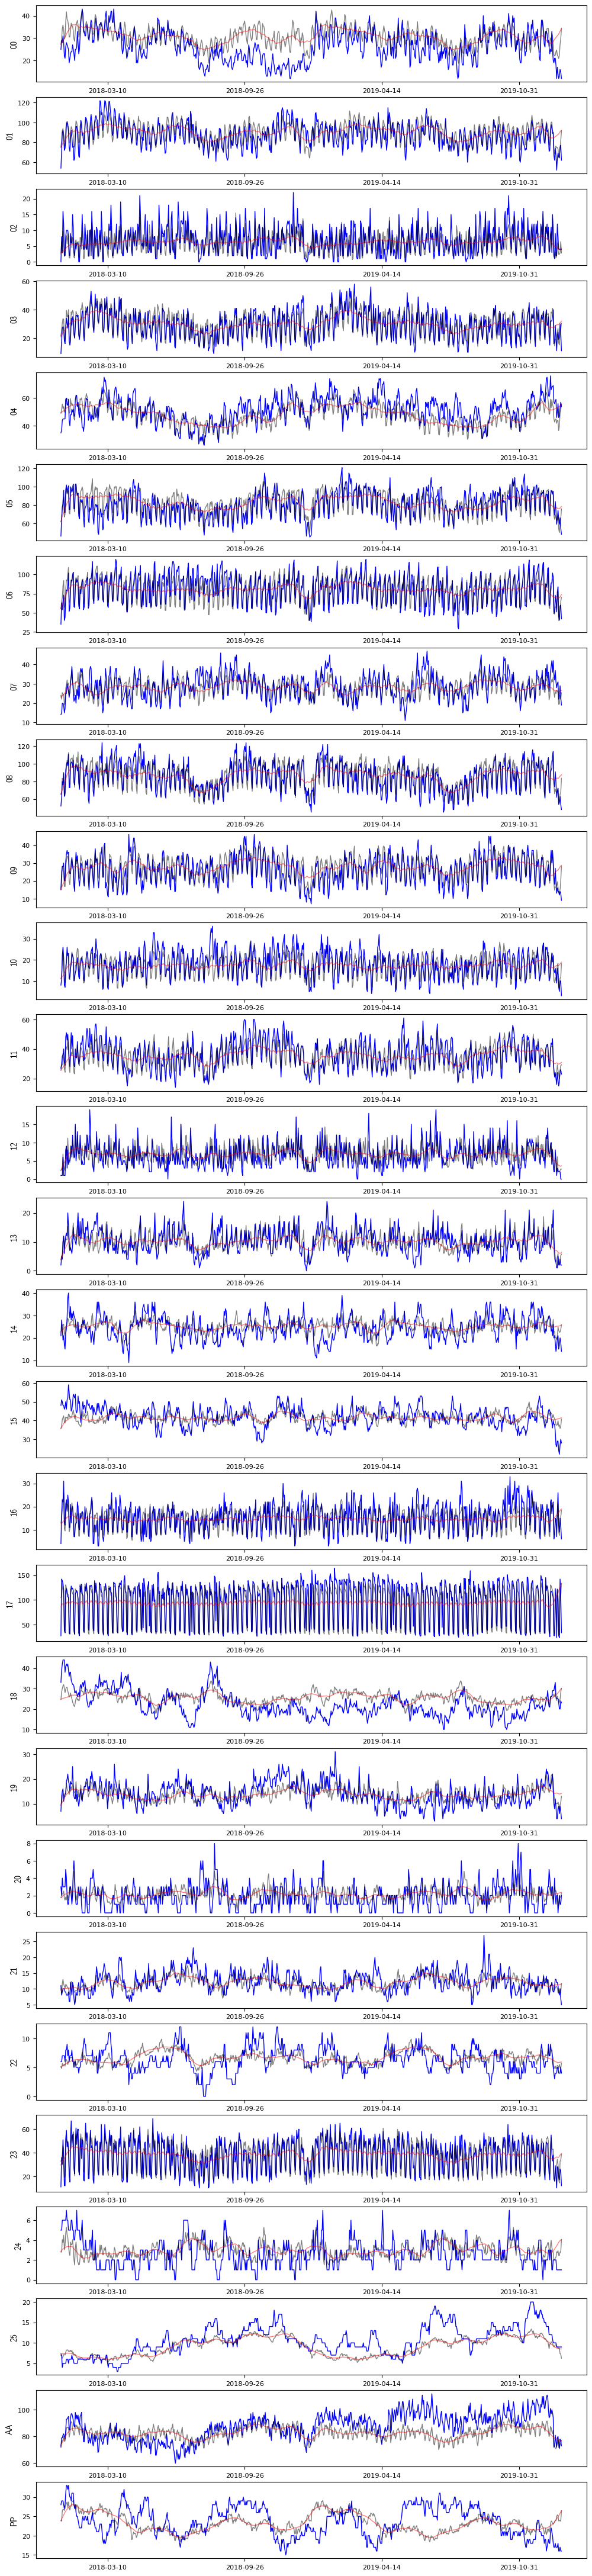

In [25]:
plot_start = pd.to_datetime('2018-01-01')
plot_end = pd.to_datetime('2020-01-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = MDC_keys

multi_index = pd.MultiIndex.from_product([MDC_plot,plot_time])
baseline_in_date_form = pd.Series(index=multi_index,dtype="float")
for idx,(disease,date) in enumerate(multi_index):
    baseline_in_date_form[idx] = baseline_mean.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

fig,axs = plt.subplots(len(MDC_plot),1,figsize=(12,len(MDC_plot)*2))
for idx,disease in enumerate(MDC_plot):
    hospitalizations_plot = hospitalizations.loc[(disease,plot_time)]
    baseline_plot = baseline_in_date_form.loc[(disease,plot_time)]
    baseline_smooth = savitzky_golay(baseline_plot,51,3)

    axs[idx].plot(plot_time,hospitalizations_plot,linewidth=1,label=MDC_dict[disease],color='blue')
    axs[idx].plot(plot_time,baseline_plot,linewidth=1,label=MDC_dict[disease],color='black',alpha=0.5)
    axs[idx].plot(plot_time,baseline_smooth,linewidth=1,label=MDC_dict[disease],color='red',alpha=0.5)

    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_ylabel(disease,font=label_font)

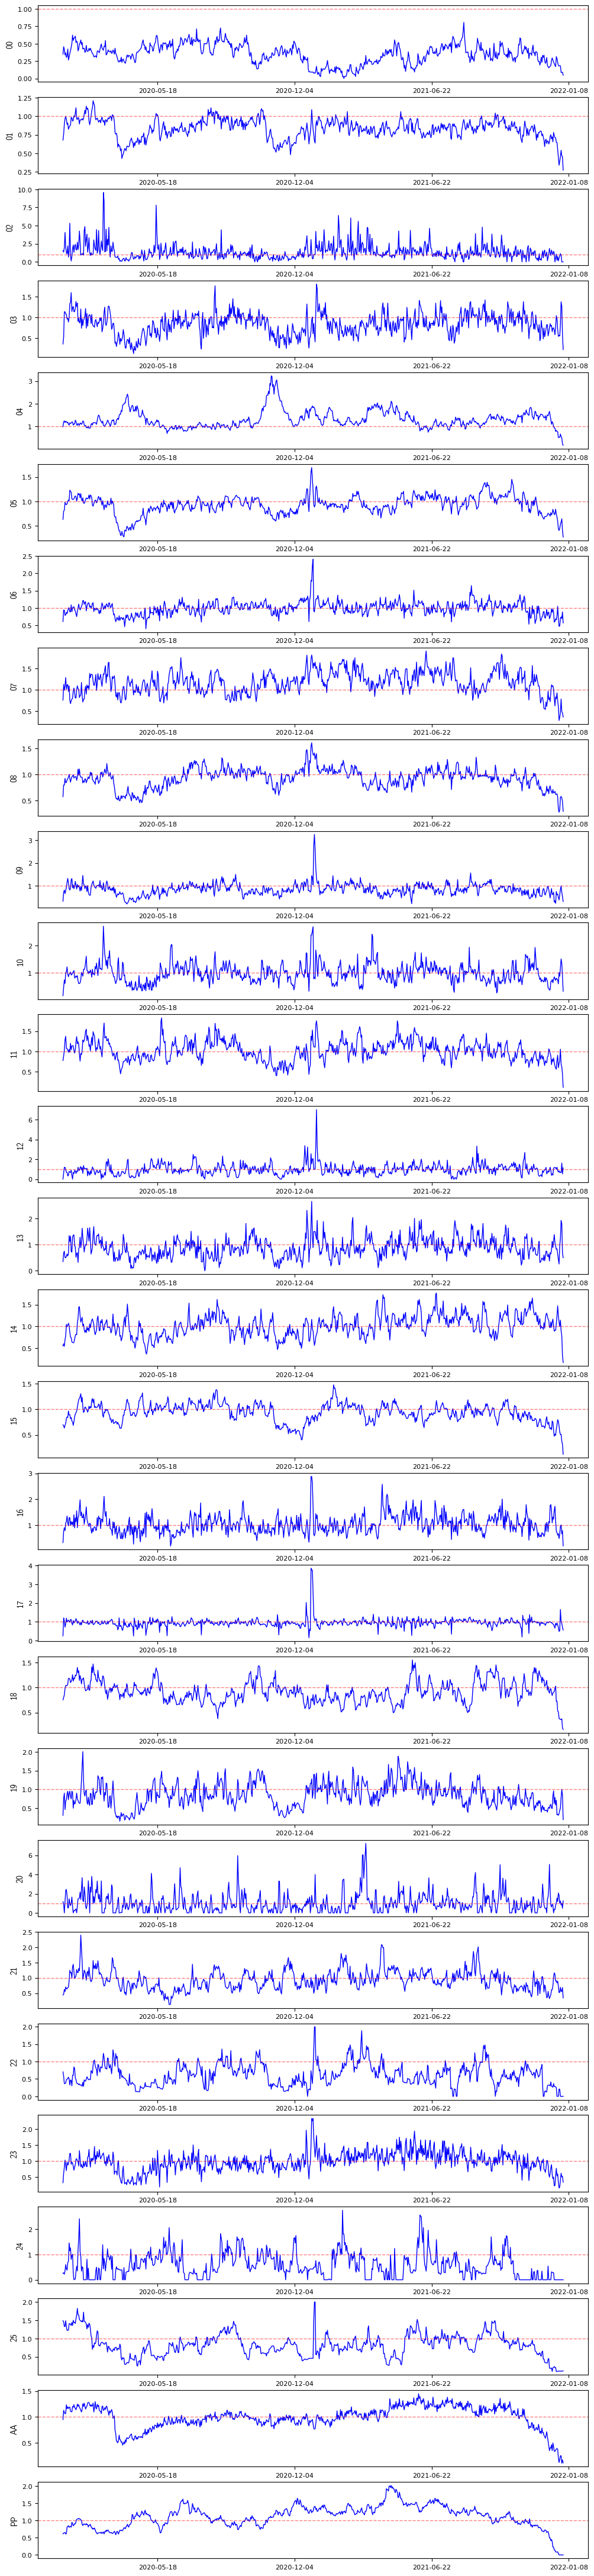

In [26]:
plot_start = pd.to_datetime('2020-01-01')
plot_end = pd.to_datetime('2021-12-31')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = MDC_keys

fig,axs = plt.subplots(len(MDC_plot),1,figsize=(12,len(MDC_plot)*2))
for idx,disease in enumerate(MDC_plot):
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    mean = hospitalizations_normalized.loc[(disease,plot_time)]
    #lower = hospitalizations_normalized_quantiles['q0.025'].loc[(disease,plot_time)]
    #upper = hospitalizations_normalized_quantiles['q0.975'].loc[(disease,plot_time)]
    axs[idx].plot(plot_time,mean,linewidth=1,label=MDC_dict[disease],color='blue')
    #as[idx]x.fill_between(plot_time,lower,upper, color='black',alpha=0.5)
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    #as[idx]x.set_title(disease,font=label_font)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_ylabel(disease,font=label_font)